In [1]:
import numpy as np
from scipy.stats.qmc import Halton
import matplotlib.pyplot as plt
import trimesh
from scipy.interpolate import Rbf, RBFInterpolator
from skimage import measure

from vpython import (
    canvas, triangle, vector, vertex, color, quad, distant_light, local_light, points
)

<IPython.core.display.Javascript object>

In [2]:
def le_random(a=50, b=-50):
    rangeval = a - b
    rng = np.random.default_rng()
    rand = Halton(3, seed=rng)
    rand_num = rand.random(3)
    val01 = int(rand_num[0][0] * rangeval + b)
    val02 = int(rand_num[0][1] * rangeval + b)
    val03 = int(rand_num[0][2] * rangeval + b)
    return (val01 + val02 + val03) / 3

le_random(50, -50)

12.333333333333334

In [3]:
dim = 30 # MUST even plz
if dim%2 != 0:
    dim = dim - (dim%2)

src_val = 50
target_val = 20
delta = 0.75

span = 2000

center = 0

In [4]:
obs = []
nobs = 0

step = (span/dim)
vstep = 5
start = 0

zi = np.arange(0, dim) * (-step) + start
vi = np.arange(0, dim)
for i in range(len(vi)):
    val = vstep * i
    if i > dim/2:
        val = vstep * (dim - i)
    vi[i] = val
# vi[15:] = 10
ix = 0
iy = 0

while nobs < 1e4:
    x = le_random(span, -span)
    y = le_random(span, -span)
    cx = np.abs(center - np.abs(x - center))
    cy = np.abs(center - np.abs(y - center))
    cr = np.sqrt(cx**2 + cy**2)
#     print(x, y, cr)
    row_obs = [
        [
            x,
            y,
            zi[i],
            (vi[i] / cr) * src_val
        ]
        for i in range(len(vi))
    ]
#     print(x, y, row_obs)
    obs += row_obs
    nobs += len(vi)

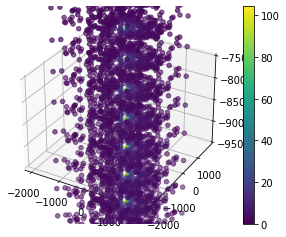

In [5]:
x = [item[0] for item in obs]
y = [item[1] for item in obs]
z = [item[2] for item in obs]
d = [item[3] for item in obs]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(x, y, z, c=d)
ax.set_zlim(-950,-750)
fig.colorbar(p)
plt.show()

In [6]:
def le_norm(val=0, maxval=1, minval=0):
    return val / (maxval - minval)

le_norm()

0.0

In [17]:
xyz = [item[:3] for item in obs]
# le_val = d

maxd = max(d)
mind = min(d)

le_color = [
    [
        int((1 - le_norm(item, maxd, mind)) * 255),
        int(le_norm(item, maxd, mind) * 255),
        0,
    ]
    for item in d
]

le_color = np.asarray(le_color)
# print(min(le_color.reshape(-1)), max(le_color.reshape(-1)))

points = trimesh.points.PointCloud(
    vertices=xyz,
    colors=le_color,
)

s = trimesh.Scene()
s.add_geometry(trimesh.creation.axis())
s.add_geometry(points)
s.show(viewer='notebook')

In [39]:
le_p = xyz[:20]
print(len(le_p), len(le_p[:-1]))

20 19


In [59]:
len(p.entities)

1

In [62]:
from shapely.geometry import Polygon, LineString, MultiLineString

le_p = xyz[:20]
le_segs = [
    [np.multiply(item, 1), np.multiply(le_p[i+1], 1)]
    for i, item in enumerate(le_p[:-1])
]
le_segs = np.asarray(le_segs)

p = trimesh.load_path(le_segs)
p.colors = [[0, 0, 0] for _ in p.entities]

s = trimesh.Scene()

s.add_geometry(trimesh.creation.axis())
s.add_geometry(p)
s.show(viewer='notebook')

(19, 2, 3) [[ 389.66666667 1478.            0.        ]
 [ 389.66666667 1478.          -66.66666667]]
(100, 2, 3) [[0.71688279 0.92848694 0.52927021]
 [0.15966451 0.20001689 0.76176832]]


In [8]:
# create 10x10X10 surface (?)

X = np.linspace(
    start=min(x),
    stop=max(x),
    num=dim
)

Y = np.linspace(
    start=min(y),
    stop=max(y),
    num=dim
)

Z = np.linspace(
    start=min(z),
    stop=max(z),
    num=dim
)

XD, YD, ZD = np.meshgrid(X, Y, Z)

In [9]:
%%time
# using interpolate.Rbf

rbfi = Rbf(
    x,
    y,
    z,
    d,
)
# DD = rbfi(XD, YD, ZD)
# print(DD.shape)

CPU times: user 2min 1s, sys: 13.8 s, total: 2min 15s
Wall time: 14.6 s


In [10]:
DD = rbfi(XD, YD, ZD)
print(DD.shape)

(30, 30, 30)


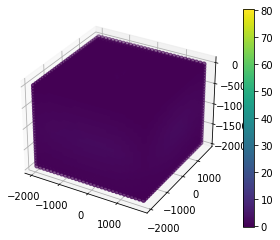

In [11]:
xplot = XD.reshape(-1)
yplot = YD.reshape(-1)
zplot = ZD.reshape(-1)
dplot = DD.reshape(-1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(xplot, YD.reshape(-1), ZD.reshape(-1), c=DD.reshape(-1), vmin=min(d), vmax=max(d))
p = ax.scatter(xplot, yplot, zplot, c=dplot)
fig.colorbar(p)
plt.show()

In [12]:
%%time
# using RBFInterpolator

# 3d mesh cannot use 'thin_plate_spline', qubic, quintic why?

# xyz = [[item, y[i], z[i]] for i, item in enumerate(x)]
rbfi2 = RBFInterpolator(
    xyz,
    d,
#     neighbors=None,
#     kernel='cubic',
)

CPU times: user 2min 1s, sys: 6.43 s, total: 2min 7s
Wall time: 11.9 s


In [13]:
XYZ = []
for x_ in X:
    for y_ in Y:
        for z_ in Z:
            XYZ.append([x_, y_, z_])
print(np.shape(XYZ))
DD = rbfi2(XYZ)
print(DD.shape)

(27000, 3)
(27000,)


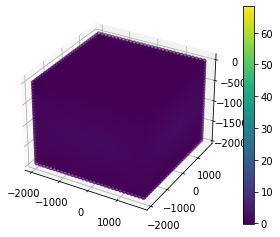

In [14]:
xplot = XD.reshape(-1)
yplot = YD.reshape(-1)
zplot = ZD.reshape(-1)
dplot = DD.reshape(-1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(xplot, YD.reshape(-1), ZD.reshape(-1), c=DD.reshape(-1), vmin=min(d), vmax=max(d))
p = ax.scatter(xplot, yplot, zplot, c=dplot)
fig.colorbar(p)
plt.show()

use [marching_cubes](https://stackoverflow.com/questions/64134974/how-to-plot-a-python-3-dimensional-level-set) to create isosurface

use [mayavi](https://docs.enthought.com/mayavi/mayavi/mlab_3d_plotting_functions.html?highlight=vertices) to plot 3d yes idk maybe

In [15]:
XYZ = np.asarray(XYZ)

le_volume = [item for item in DD]
le_volume = np.asarray(le_volume)
le_volume = le_volume.reshape(dim, dim, -1)

# print(le_volume.shape, le_volume.shape)

le_points, le_trong, _, _ = measure.marching_cubes(
    le_volume,
    level=target_val,
    spacing=(1.0, 1.0, 1.0),
    gradient_direction='descent',
    step_size=1,
    allow_degenerate=True,
    method='lewiner',
    mask=None,
)

xdim = [min(xplot), max(xplot)]
ydim = [min(yplot), max(yplot)]
zdim = [min(zplot), max(zplot)]

def interp_range_pos(pos=0, ndata=10, drange=[0, 1]):
    return ((pos/ndata) * (drange[1] - drange[0]) + drange[0])

for i in range(len(le_points)):
    le_points[i][0] = interp_range_pos(le_points[i][0], dim, xdim)
    le_points[i][1] = interp_range_pos(le_points[i][1], dim, ydim)
    le_points[i][2] = interp_range_pos(le_points[i][2], dim, zdim)

le_x = [item[0] for item in le_points]
le_y = [item[1] for item in le_points]
le_z = [item[2] for item in le_points]
le_d = le_volume.reshape(-1)

# print(le_d)
# print(le_color)
print(max(le_x), min(le_x), 'x')
print(max(le_y), min(le_y), 'y')
print(max(le_z), min(le_z), 'z')

s = trimesh.Scene()

mesh = trimesh.Trimesh(
    vertices=le_points,
    faces=le_trong,
#     face_normals=[-1, -1, -1],
)

print(mesh.body_count)

s.add_geometry(points)
s.add_geometry(mesh)

s.show(viewer='notebook')

123.79433 -248.22061 x
125.20086 -247.95215 y
-340.66473 -1721.5416 z
1


In [16]:
le_byte = trimesh.exchange.gltf.export_glb(s)
f = open("ye.glb", "wb")
f.write(le_byte)
f.close()

https://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html